In [91]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
%%html
<style>
table {float:left}
</style>

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Training Data

In [26]:
train_data = pd.read_csv('data/car_breakdown_train.tsv', sep='\t', header=0)
train_data.head()

,vehicleId,days,ecoMode,cityMode,sportMode,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100,39.06,23.4190
1,1,2,0.0019,-0.0003,100,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100,39.00,23.4236
2,1,3,-0.0043,0.0003,100,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100,38.95,23.3442
3,1,4,0.0007,0.0000,100,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100,38.88,23.3739
4,1,5,-0.0019,-0.0002,100,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100,38.90,23.4044


In [49]:
train_data['vehicleId'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [17]:
train_data.isnull().sum()

vehicleId    0
days         0
ecoMode      0
cityMode     0
sportMode    0
s1           0
s2           0
s3           0
s4           0
s5           0
s6           0
s7           0
s8           0
s9           0
s10          0
s11          0
s12          0
s13          0
s14          0
s15          0
s16          0
s17          0
s18          0
s19          0
s20          0
s21          0
dtype: int64

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
vehicleId    20631 non-null int64
days         20631 non-null int64
ecoMode      20631 non-null float64
cityMode     20631 non-null float64
sportMode    20631 non-null int64
s1           20631 non-null float64
s2           20631 non-null float64
s3           20631 non-null float64
s4           20631 non-null float64
s5           20631 non-null float64
s6           20631 non-null float64
s7           20631 non-null float64
s8           20631 non-null float64
s9           20631 non-null float64
s10          20631 non-null float64
s11          20631 non-null float64
s12          20631 non-null float64
s13          20631 non-null float64
s14          20631 non-null float64
s15          20631 non-null float64
s16          20631 non-null float64
s17          20631 non-null int64
s18          20631 non-null int64
s19          20631 non-null int64
s20          20631 non-null float64
s21

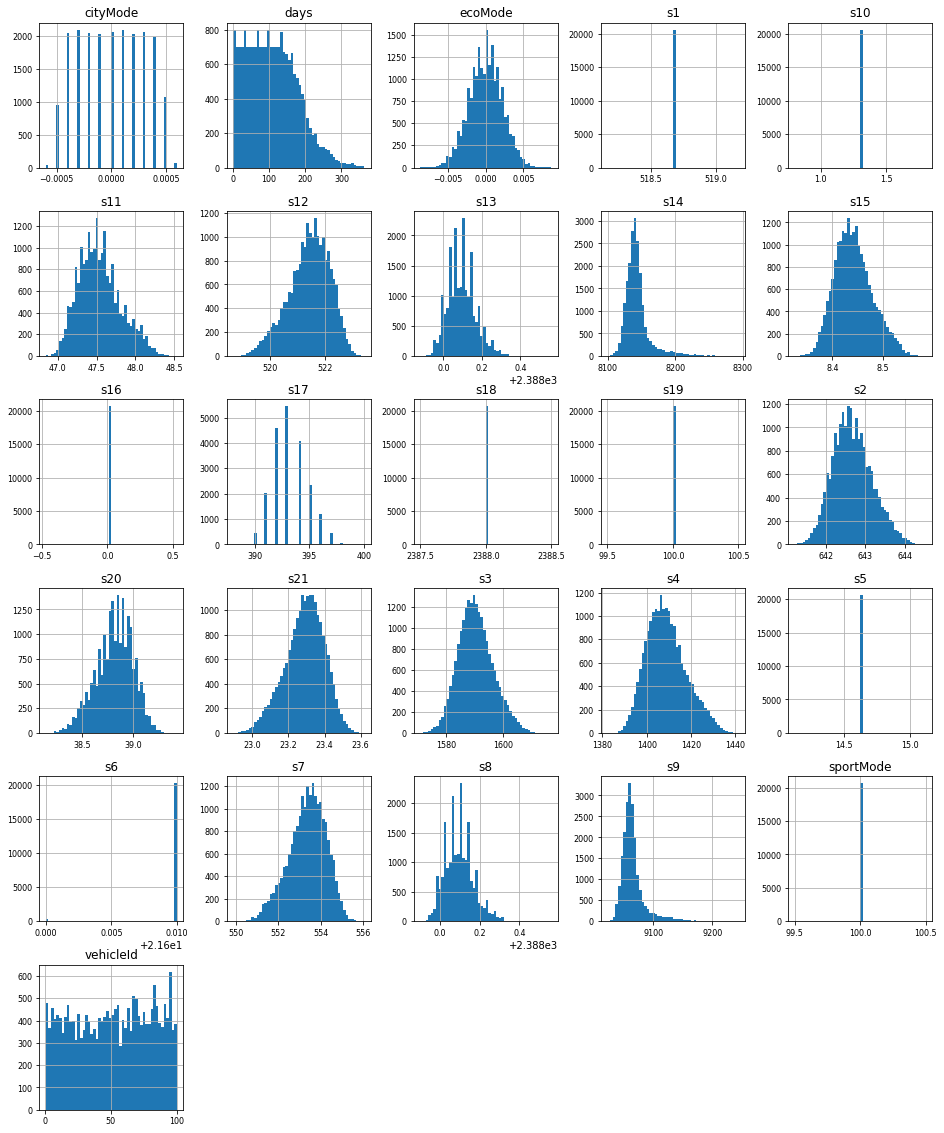

In [14]:
train_data.loc[:,:].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

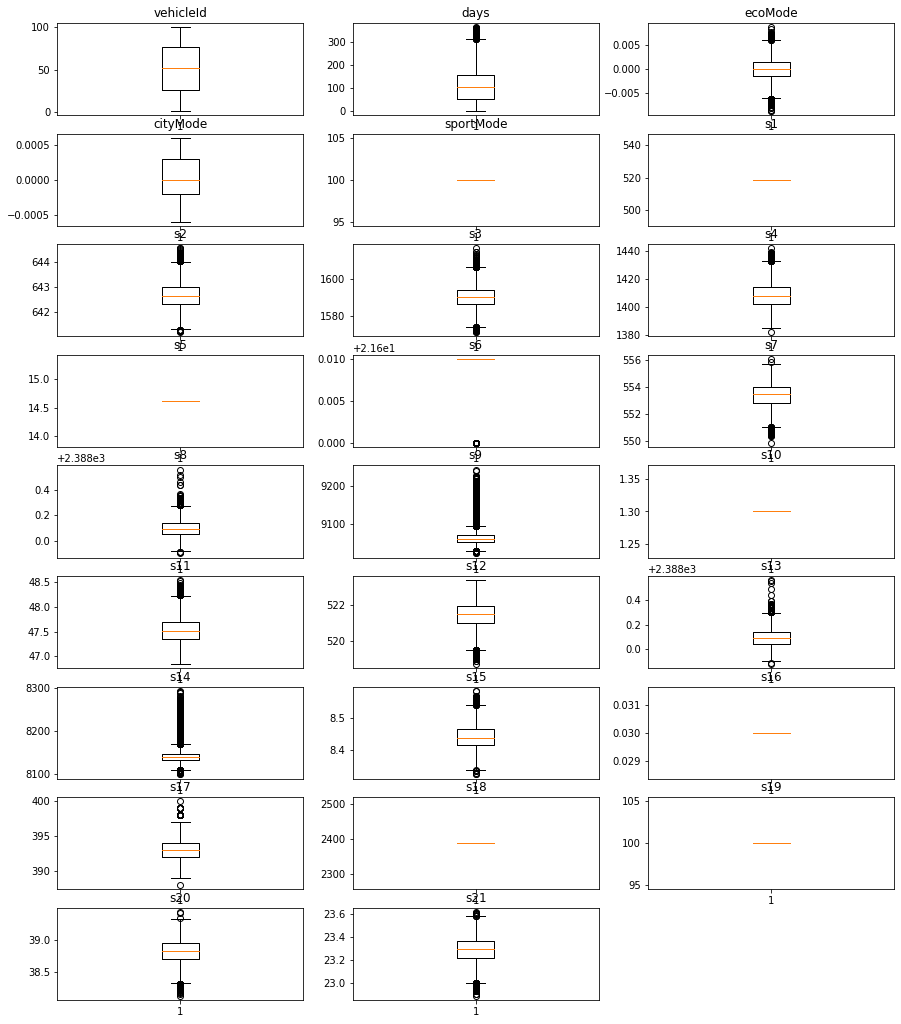

In [16]:
plt.figure(figsize=(15, 20))
for i,j in enumerate(train_data.columns):
    plt.subplot(10, 3, i+1)
    plt.boxplot(train_data[j])
    plt.title(j)

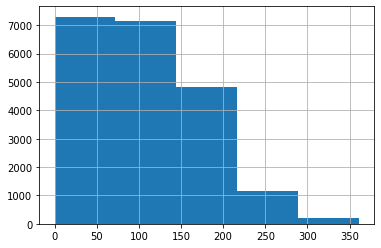

In [16]:
train_data['RUL'].hist(bins = 5)
# plt.xlim(0,250)

In [27]:
# feature_engineering
sensor_cols = ['s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

sensor_av_cols = [nm.replace('s', 'av') for nm in sensor_cols]
sensor_sd_cols = [nm.replace('s', 'sd') for nm in sensor_cols]

df = pd.DataFrame()
for i in train_data['vehicleId'].unique():
    data_id = train_data[train_data['vehicleId'] == i].loc[:,sensor_cols]
    ra = data_id.rolling(5, min_periods=1).mean()
    ra.columns = sensor_av_cols
    sd = data_id.rolling(5, min_periods=1).std().fillna(0)
    sd.columns = sensor_sd_cols
    new_ftrs = pd.concat([data_id,ra,sd], axis=1)
    # add the new features rows to the output dataframe
    df = pd.concat([df,new_ftrs])
train_data = pd.concat([train_data.iloc[:,:5],df],axis = 1)
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_data.groupby('vehicleId')['days'].max()).reset_index()
rul.columns = ['vehicleId', 'max']
train_data = train_data.merge(rul, on=['vehicleId'], how='left')
train_data['RUL'] = train_data['max'] - train_data['days']
train_data.drop('max', axis=1, inplace=True)
# creating_label_multiclass
train_data['label'] = train_data['RUL'].apply(lambda x: 0 if x<15 else 1 if 15<=x<45 else 2 if 45<=x<90 else 3 if 90<=x<150 else 4)
# creating_label_binaryclass
train_data['label_bc'] = train_data['RUL'].apply(lambda x: 1 if x<=30 else 0)

In [28]:
train_data

,vehicleId,days,ecoMode,cityMode,sportMode,s1,s2,s3,s4,s5,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,RUL,label,label_bc
0,1,1,-0.0007,-0.0004,100,518.67,641.82,1589.70,1400.60,14.62,...,0.000000,0.0,0.000000e+00,0.0,0.0,0.000000,0.000000,191,4,0
1,1,2,0.0019,-0.0003,100,518.67,642.15,1591.82,1403.14,14.62,...,0.008697,0.0,0.000000e+00,0.0,0.0,0.042426,0.003253,190,4,0
2,1,3,-0.0043,0.0003,100,518.67,642.35,1587.99,1404.20,14.62,...,0.007640,0.0,1.154701e+00,0.0,0.0,0.055076,0.044573,189,4,0
3,1,4,0.0007,0.0000,100,518.67,642.35,1582.79,1401.87,14.62,...,0.028117,0.0,1.000000e+00,0.0,0.0,0.076322,0.037977,188,4,0
4,1,5,-0.0019,-0.0002,100,518.67,642.37,1582.85,1406.22,14.62,...,0.025953,0.0,1.095445e+00,0.0,0.0,0.073621,0.033498,187,4,0
5,1,6,-0.0043,-0.0001,100,518.67,642.10,1584.47,1398.37,14.62,...,0.025727,0.0,1.140175e+00,0.0,0.0,0.051186,0.031436,186,4,0
6,1,7,0.0010,0.0001,100,518.67,642.48,1592.32,1397.77,14.62,...,0.023476,0.0,1.140175e+00,0.0,0.0,0.086718,0.021634,185,4,0
7,1,8,-0.0034,0.0003,100,518.67,642.56,1582.96,1400.97,14.62,...,0.022477,0.0,8.366600e-01,0.0,0.0,0.086487,0.034405,184,4,0
8,1,9,0.0008,0.0001,100,518.67,642.12,1590.98,1394.80,14.62,...,0.020740,0.0,8.366600e-01,0.0,0.0,0.077136,0.038939,183,4,0
9,1,10,-0.0033,0.0001,100,518.67,641.71,1591.24,1400.46,14.62,...,0.020493,0.0,8.366600e-01,0.0,0.0,0.062849,0.058103,182,4,0


In [72]:
df.shape

(20631, 63)

In [97]:
# dumping multiclass labels
train_data['label'].to_csv('y_train2.csv',index = False)
# dumping binaryclass labels
train_data['label_bc'].to_csv('y_train_bc.csv',index = False)


/home/quantiphi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


In [29]:
# save the training data to csv file for later use
train_data.to_csv('train_2.csv', index=False)

## How the training data is arranged.

|**Field**|**Description**|
|:---------|:---------------|
|**vechicleId**|unique id of the vehicle in the fleet|
|**days**|number of days passed so far|
|**ecoMode**|eco mode nob setting used for the day|
|**cityMode**|city mode nob setting used for the day|
|**sportMode**|sport mode nob setting used for the day|
|**s1**|reading form sensor 1|
|**s2**|reading form sensor 2|
|**s3**|reading form sensor 3|
| ... | ... |
|**s20**|reading form sensor 20|
|**s21**|reading form sensor 21|

The data is arranged as per above columns. Rows are grouped by **vehicleId**, with **days** in increasing order, representing the state of the car on that day, in a time series manner.

The last day of for the particular **vehicleId** is the day, when the state of it was so bad, that it broke down.
e.g. in the following case, **vehicleId** = 1, broke down on 192nd day

# Test Data

In [30]:
test_data = pd.read_csv('data/car_breakdown_test.tsv', sep='\t', header=0)
test_data.head()

,vehicleId,days,ecoMode,cityMode,sportMode,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100,38.86,23.3735
1,1,2,-0.0027,-0.0003,100,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100,39.02,23.3916
2,1,3,0.0003,0.0001,100,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100,39.08,23.4166
3,1,4,0.0042,0.0000,100,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100,39.00,23.3737
4,1,5,0.0014,0.0000,100,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100,38.99,23.4130


In [31]:
# feature_engineering
sensor_cols = ['s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

sensor_av_cols = [nm.replace('s', 'av') for nm in sensor_cols]
sensor_sd_cols = [nm.replace('s', 'sd') for nm in sensor_cols]

df = pd.DataFrame()
for i in test_data['vehicleId'].unique():
    data_id = test_data[test_data['vehicleId'] == i].loc[:,sensor_cols]
    ra = data_id.rolling(5, min_periods=1).mean()
    ra.columns = sensor_av_cols
    sd = data_id.rolling(5, min_periods=1).std().fillna(0)
    sd.columns = sensor_sd_cols
    new_ftrs = pd.concat([data_id,ra,sd], axis=1)
    # add the new features rows to the output dataframe
    df = pd.concat([df,new_ftrs])
# test_data = pd.concat([test_data.iloc[:,:5],df],axis = 1)
test_data = test_data.iloc[:,:5].join(df)
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
test_data = test_data.groupby(['vehicleId']).last().reset_index()
test_data = test_data.merge(test_truth_data,how = 'left',on = 'vehicleId')
# creating_label_mulitclass
test_data['label'] = test_data['RUL'].apply(lambda x: 0 if x<15 else 1 if 15<=x<45 else 2 if 45<=x<90 else 3 if 90<=x<150 else 4)
# creating_label_binaryclass
test_data['label_bc'] = test_data['RUL'].apply(lambda x: 1 if x<=30 else 0)
# save the training data to csv file for later use
test_data.to_csv('test_2.csv', index=False)

In [21]:
test_data

,vehicleId,days,ecoMode,cityMode,sportMode,s1,s2,s3,s4,s5,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,RUL,label,label_bc
0,1,31,-0.0006,0.0004,100,518.67,642.58,1581.22,1398.91,14.62,...,0.021174,0.0,0.707107,0.0,0.0,0.124016,0.025037,112,3,0
1,2,49,0.0018,-0.0001,100,518.67,642.55,1586.59,1410.83,14.62,...,0.011429,0.0,1.095445,0.0,0.0,0.069785,0.027820,98,3,0
2,3,126,-0.0016,0.0004,100,518.67,642.88,1589.75,1418.89,14.62,...,0.030924,0.0,0.836660,0.0,0.0,0.143631,0.018966,69,2,0
3,4,106,0.0012,0.0004,100,518.67,642.78,1594.53,1406.88,14.62,...,0.021249,0.0,1.341641,0.0,0.0,0.126372,0.021106,82,2,0
4,5,98,-0.0013,-0.0004,100,518.67,642.27,1589.94,1419.36,14.62,...,0.009627,0.0,0.547723,0.0,0.0,0.091924,0.101100,91,3,0
5,6,105,0.0076,-0.0003,100,518.67,643.05,1586.94,1404.49,14.62,...,0.007488,0.0,0.447214,0.0,0.0,0.153395,0.071794,93,3,0
6,7,160,0.0016,-0.0001,100,518.67,642.10,1589.59,1413.57,14.62,...,0.016718,0.0,0.000000,0.0,0.0,0.098387,0.063694,91,3,0
7,8,166,0.0016,-0.0005,100,518.67,642.59,1591.91,1413.89,14.62,...,0.018301,0.0,0.447214,0.0,0.0,0.054314,0.036437,95,3,0
8,9,55,-0.0003,0.0004,100,518.67,642.27,1593.61,1410.27,14.62,...,0.013525,0.0,0.836660,0.0,0.0,0.015166,0.047928,111,3,0
9,10,192,-0.0018,0.0004,100,518.67,643.00,1589.50,1398.99,14.62,...,0.030489,0.0,0.836660,0.0,0.0,0.087920,0.055861,96,3,0


In [101]:
# dumping multiclass label
test_data['label'].to_csv('y_test2.csv',index = False)
# dumping binary class label
test_data['label_bc'].to_csv('y_test_bc.csv',index = False)

/home/quantiphi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


## How the test data is arranged.

Test data has the exactly same schema as the training data. Except the fact that the data doesn't represent when the failure has occurrs, in other words the last row for a given **vehicleId** doesn't represent the day of breakdown(it has happened earlier than the last row).


## Ground truth test data

The **Remaining Useful Day(RUL)** as calculated from the first day for a particular **vehicleId** is present in the ground truth file.

In [14]:
test_truth_data = pd.read_csv('data/car_breakdown_test_truth.tsv', sep='\t', header=0)
test_truth_data.head()

,vehicleId,RUL
0,1,112
1,2,98
2,3,69
3,4,82
4,5,91


In [15]:
test_truth_data

,vehicleId,RUL
0,1,112
1,2,98
2,3,69
3,4,82
4,5,91
5,6,93
6,7,91
7,8,95
8,9,111
9,10,96


e.g. The **vehicleId** = 1 in the test data can run another 112 days before it fails.